# Notebook de développement du modèle

Ce dataset comporte peu de données pour chaque classe (entre 60 et 100). <br>
Ainsi il faudra adapter les méthodes d'apprentissages.

## Data Management

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image
import glob
import matplotlib.pyplot as plt
import seaborn as sn 
import tensorflow as tf
import keras
from keras import  layers, models


In [35]:
fish_list=['apognon','epinephelus_marginatus','girelle_paon','pempheris_vanicolensis','sparisoma_cretense']
original_data_path = './data/original/'
synthetic_data_path = './data/synthetic/'

### Rename files

In [3]:

'''
for espece in liste_poissons:
    root = r"data/generated/color/{}".format(espece)
    print(root)
    count = 0
    for dirs, subdir, files in os.walk(root):
        for file in files:
            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))
            count+=1

'''


'\nfor espece in liste_poissons:\n    root = r"data/generated/color/{}".format(espece)\n    print(root)\n    count = 0\n    for dirs, subdir, files in os.walk(root):\n        for file in files:\n            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))\n            count+=1\n\n'

### Stats

<Axes: >

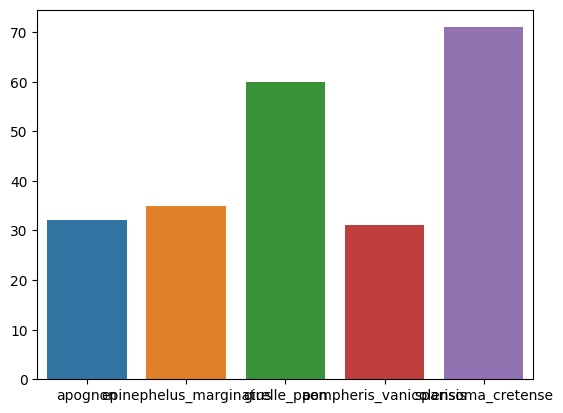

In [64]:
fish_list
nb_samples = {} 
for f in fish_list:
    nb_samples[f] = len(os.listdir('./data/original/{}'.format(f)))

nb_samples
sn.barplot(x=list(nb_samples.keys()), y=list(nb_samples.values()))


In [68]:
#move 30 first samples for each specie to the test subset
for fish in fish_list:
   for i in range(31,61,1):
      shutil.copy('./data/original/'+'{}/{}.jpg'.format(fish,fish+str(i)),'./data/validation/'+'{}/{}.jpg'.format(fish,fish+str(i)))

### Generation d'image

In [62]:
data_augmentation = layers.RandomRotation(0.4)
 
#function that take in arguments the path to the original image
#the destination path
#a counter that is the number of the image for the current fold on which we are looping
#create 3 new images from the original by randomly rotating it and save them in the designated folder
def generate_save_new_img_from_path(original_image_path,destination_image_path,counter):
    image = tf.io.read_file(original_image_path)
    image = tf.image.decode_png(image,channels=3)
    for k in range(3):
      new_image = data_augmentation(image)
      tf.keras.utils.save_img(destination_image_path+str(counter+k)+'.jpg', new_image)

In [63]:
for specie in fish_list:
    counter = 0
    for i in range(31,60,1):
        generate_save_new_img_from_path(original_data_path+'{}/{}{}'.format(specie,specie,i)+'.jpg',synthetic_data_path+'/{}/{}'.format(specie,specie),counter)
        counter+=3

## Création du modèle

### Modele créer en local

Pour ce modèle il n'y aura pas de données de test, seulement les données de validations à cause du nombre restreint de données

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 150, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
epochs=10
history = model.fit(
  training_data,
  y_training_data,
  validation_data=(test_data,y_test_data),
  epochs=epochs,
  batch_size=5
)

Epoch 1/10
226/226 [==============================] - 54s 223ms/step - loss: 1.5235 - accuracy: 0.3052 - val_loss: 1.4030 - val_accuracy: 0.3799
Epoch 2/10
226/226 [==============================] - 48s 211ms/step - loss: 1.3160 - accuracy: 0.3886 - val_loss: 1.2680 - val_accuracy: 0.3826
Epoch 3/10
226/226 [==============================] - 48s 211ms/step - loss: 1.1683 - accuracy: 0.5067 - val_loss: 1.0273 - val_accuracy: 0.6121
Epoch 4/10
226/226 [==============================] - 48s 210ms/step - loss: 0.9605 - accuracy: 0.6335 - val_loss: 0.9110 - val_accuracy: 0.6702
Epoch 5/10
226/226 [==============================] - 48s 210ms/step - loss: 0.8370 - accuracy: 0.6619 - val_loss: 0.8702 - val_accuracy: 0.6544
Epoch 6/10
226/226 [==============================] - 48s 211ms/step - loss: 0.7567 - accuracy: 0.7054 - val_loss: 0.7388 - val_accuracy: 0.7441
Epoch 7/10
226/226 [==============================] - 47s 209ms/step - loss: 0.6341 - accuracy: 0.7551 - val_loss: 0.7182 - val_ac

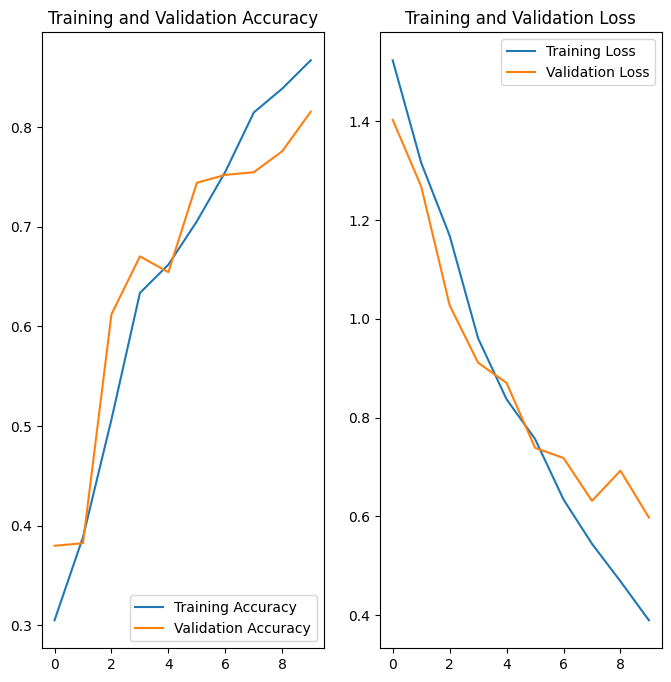

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Note: les données d'entrainement ont été obtenu par data augmention via les données de validations, il y a donc un risque d'overfiting.